# Natural Language Processing with Disaster Tweets
### University of Colorado Boulder
DTSA 5511

Deep Learning

Spring 2024

Anna Sanders

Twitter, or as it is now named X, is a social media platform where any person can 'tweet' about anything. Tweets historically had a character limit, and while you can 'multi-tweet' about a topic, most people write short tweets (less than 200 characters).

As the effects of climate change worsen, so do natural disasters. Many people often flock to social media to post about a disaster, with some using it as a way to inform others or to indicate that they are currently in a disaster area. Because of this, it is important to be able to quickly classify tweets as those tweeting about actual natural disasters and those not. Filtering can help connect resuce workers with those potentially in danger of the disaster itself or amplify conditions and spread of the disaster.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re
import string

# Metrics
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
# decision tree model

# NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# NN
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras import utils
import tensorflow_hub as hub

from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Dense, TextVectorization
from keras.optimizers import Adam

## Load Data

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
print('Train Length:', len(train))
print('Test Length:', len(test))
print('Split: %.2f' %(len(test)/(len(test)+len(train))*100),'%')

Train Length: 7613
Test Length: 3263
Split: 30.00 %


In [4]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

The training data looks to be almost evenly split between 1s and 0s, or disaster tweets and non-disaster tweets.

In [5]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Looking at the dataframe itself, there are two additional columns, called keyword and location, that exist. From the dataframe preview, it looks like some of these values are NANs. We can see how many non-NAN values are below.

In [6]:
print('Non-NAN keyword:', len(train[train['keyword'].isna()==False]))
print('Non-NAN location:', len(train[train['location'].isna()==False]))

Non-NAN keyword: 7552
Non-NAN location: 5080


In [7]:
np.unique(train[train['keyword'].isna()==False]['keyword'])

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [8]:
np.unique(train[train['location'].isna()==False]['location'])

array(['  ', '  Glasgow ', '  Melbourne, Australia', ...,
       'å¡å¡Midwest \x89Û¢\x89Û¢', 'åÊ(?\x89Û¢`?\x89Û¢å«)??',
       'åø\\_(?)_/åø'], dtype=object)

Looking at the actual outputs of these two columns, the keyword seems to hold keyworks, likely used in the tweet text, that relate to natural disasters and other disasters. We will leave this column from the training data to start, as we would need to categorically encode this column.

The location column clearly holds location, but seems to be less organized than the keywork column. For this reason, the location column will not be used in modeling.

In [9]:
df = train[train['keyword'].isna()==False]['keyword'].value_counts().reset_index()
df.head(20)

,keyword,count
0,fatalities,45
1,deluge,42
2,armageddon,42
3,sinking,41
4,damage,41
5,harm,41
6,body%20bags,41
7,outbreak,40
8,evacuate,40
9,fear,40


In [10]:
df.tail(20)

,keyword,count
201,bombing,29
202,obliteration,29
203,sirens,29
204,snowstorm,29
205,desolate,29
206,seismic,29
207,first%20responders,29
208,rubble,28
209,demolished,28
210,deluged,27


The keywords also seem to be fairly well distributed, at most, there are 45 instances of one keyword, while the least frequent have at least 9 observations.

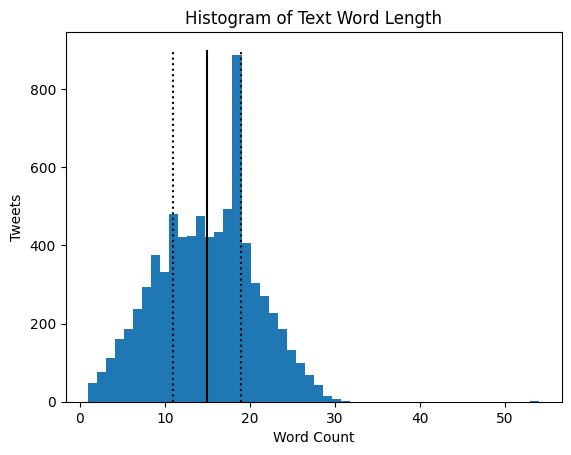

In [11]:
df = train
df['Word Count'] = df['text'].apply(lambda x: len(x.split(sep=' ')))
fig, ax = plt.subplots()
ax.hist(df['Word Count'], bins=50)
ax.set_ylabel('Tweets')
ax.set_xlabel('Word Count')
ax.set_title('Histogram of Text Word Length')
ax.vlines(df['Word Count'].quantile(0.5), 0, 900, color='black')
ax.vlines(df['Word Count'].quantile(0.25), 0, 900, color='black', linestyle='dotted')
ax.vlines(df['Word Count'].quantile(0.75), 0, 900, color='black', linestyle='dotted')
fig.show()

In [12]:
print('Median: ', df['Word Count'].quantile(0.5))
print('Q1: ', df['Word Count'].quantile(0.25))
print('Q3: ', df['Word Count'].quantile(0.75))

Median:  15.0
Q1:  11.0
Q3:  19.0


Looking at the word count of the tweets, most seem to have less than 25 words, with the median being around 15 words. This will hopefully make a sequential neural network model run okay, as there are usually less than 30 'sequences' the model needs to run through.

In [13]:
n = 10
for i in range(n):
    print('Tweet ',i,':',train.iloc[i]['text'])

Tweet  0 : Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet  1 : Forest fire near La Ronge Sask. Canada
Tweet  2 : All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Tweet  3 : 13,000 people receive #wildfires evacuation orders in California 
Tweet  4 : Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Tweet  5 : #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Tweet  6 : #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
Tweet  7 : I'm on top of the hill and I can see a fire in the woods...
Tweet  8 : There's an emergency evacuation happening now in the building across the street
Tweet  9 : I'm afraid that the tornado is coming to our area...


Looking at the first 10 tweets, we can see that tweets often have special characters, like hashtags. These will need to be cleaned to do Natural Language Processing.

## Natural Language Processing
Similar to the BBC News Classification Project in DTSA 5509, we can use spaCy to help clean these tweets. We will first remove all punctuation and the common English language stop words.

In [14]:
# SpaCy Stop Words
print(len(nlp.Defaults.stop_words), list(nlp.Defaults.stop_words))

326 ['else', 'namely', 'nowhere', 'still', 'his', 'they', 'much', 'between', 'meanwhile', 'such', 'somewhere', 'seeming', "'ll", 'really', 'onto', 'doing', 'mine', 'every', 'everything', 'all', 'latter', 'over', 'some', 'were', 'alone', 'whither', 'before', 'whereafter', 'wherever', 'should', 'must', 'as', 'i', 'neither', 'yourselves', 'ten', 'does', 'one', 'your', 'yourself', 'beside', 'either', 'though', 'hereafter', 'had', 'below', 'show', 'against', 'where', 'whom', 'there', 'nothing', 'thereafter', 'since', 'along', 'thru', 'not', 'are', 'part', 'which', 'afterwards', 'a', 'well', 'six', 'also', 'during', 'too', 'out', 'throughout', 'indeed', 'quite', 'anyway', '‘re', 'herein', 'less', 'few', 'keep', 'front', 'upon', 'others', 'side', 'that', 'to', 'through', 'anywhere', 'put', 'beforehand', 'top', 'always', 'did', 'by', 'serious', 'whenever', 'beyond', 'three', 'even', 'twelve', 'their', 'because', 'himself', 'both', 'third', 'whereupon', '‘d', 'how', 'after', 'latterly', 'using'

In [15]:
train_clean = train.copy()

# Remove Words Function
def remove_words(text):
    doc = nlp(text)
    n_text = [word.text for word in doc if (word not in nlp.Defaults.stop_words)] #word.text forces back to string
    return ' '.join(n_text) #forces back to full text

import re
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
def remove_emojis(data):
    return re.sub(emoj, '', data)

def remove_urls(text):
    return re.sub(r'http\S+', '', text, flags=re.MULTILINE)

train_clean['text'] = train_clean['text'].apply(remove_words)
train_clean['text'] = train_clean['text'].apply(remove_emojis)
train_clean['text'] = train_clean['text'].apply(remove_urls)

# Remove Punctuation (after removal of stop words with punctuation)
train_clean['text'] = train_clean['text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
train_clean['text'] = train_clean['text'].apply(lambda x: re.sub(' +', ' ', x))

In [16]:
n = 32 #tweet 31 has URLs
for i in range(n):
    print('Tweet ',i,':',train_clean.iloc[i]['text'])

Tweet  0 : Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
Tweet  1 : Forest fire near La Ronge Sask Canada
Tweet  2 : All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected
Tweet  3 : 13000 people receive wildfires evacuation orders in California
Tweet  4 : Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school
Tweet  5 :  RockyFire Update California Hwy 20 closed in both directions due to Lake County fire CAfire wildfires
Tweet  6 :  flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas
Tweet  7 : I m on top of the hill and I can see a fire in the woods 
Tweet  8 : There s an emergency evacuation happening now in the building across the street
Tweet  9 : I m afraid that the tornado is coming to our area 
Tweet  10 : Three people died from the heat wave so far
Tweet  11 : Haha South Tampa is getting flooded hah WAIT A SE

## Train Test Split

We must now split the data into training and testing subsets. The overall test subset is in a seperate dataframe, so this split will more or less act as a train and validation set. We do not know the true labels of the test data and will not know the result of the final model until we submit the generated labels to the competition.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(train_clean, test_size=0.2, stratify = train_clean['target'], random_state =101)

print('Train Length:',len(X_train), '\t Percent Disaster: %.2f' %(len(X_train[X_train['target']==1])/len(X_train)*100))
print('Test Length:',len(X_test), '\t Percent Disaster: %.2f' %(len(X_test[X_test['target']==1])/len(X_test)*100))

# Force to Tensor Datasets
tensor_train_text = tf.convert_to_tensor(X_train['text'].values)
X_train_t = tf.data.Dataset.from_tensor_slices((tensor_train_text, X_train['target']))

tensor_test_text = tf.convert_to_tensor(X_test['text'].values)
X_test_t = tf.data.Dataset.from_tensor_slices((tensor_test_text, X_test['target']))

Train Length: 6090 	 Percent Disaster: 42.97
Test Length: 1523 	 Percent Disaster: 42.94


From the conversion to tensorflow datasets, we can utilize various functions to tokenize and vectorize the tweet texts. We can start by shuffling the data and creating batch sizes. We can see the output below.

In [18]:
BATCH_SIZE = 64

train_dataset = X_train_t.shuffle(len(X_train_t), seed=101).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = X_test_t.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'Police Officer Wounded Suspect Dead After Exchanging Shots ABC News AN247'
 b'chromsucks do nt drown'
 b'Survival Kit Whistle Fire Starter Wire Saw Cree Torch Emergency Blanket S knife Full re\xc2\x89\xc3\x9b ']

labels:  [1 0 1]


## Text Vectorization

We can now apply a semi-custom standardization, which will also standardize the tweet texts and remove punctuation and special characters. We then create the vectorization layer and run just the training and validation text through to convert. Code adapted from [this tutorial](https://www.tensorflow.org/tutorials/keras/text_classification#prepare_the_dataset_for_training).

In [20]:
max_features = 10000
max_tweet_len = max(len(tweet.split(' ')) for tweet in train_clean['text'])

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_tweet_len)

train_text = train_dataset.map(lambda x, y: x) # just the text
vectorize_layer.adapt(train_text) # train vectorization

In [21]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review:", str(first_review))
print("Label:", int(first_label))
print("Vectorized review", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'USGS reports a M194 earthquake 5 km S of Volcano Hawaii on 8615 10401 UTC quake', shape=(), dtype=string)
Label: 1
Vectorized review (<tf.Tensor: shape=(1, 38), dtype=int64, numpy=
array([[1330,  845,    3, 2654,  241,  146,  650,   12,    6,  487, 1399,
          13, 5739, 5803, 1797, 4452,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


We can see from the output that the single tensor (tweet) above was "USGS reports a M194 earthquake 5 km S of Volcano Hawaii on 8615 10401 UTC quake," which does sound like a potential disaster. The label found is 1, which mean this tweet was classified as a disaster tweet. The vector created is a vector of the tweet text  with every number as a postive integer value. Each number corresponds to a unique dictionary key with will map to the exact word. The vector is 0 padded to be the same length of the longest cleaned tweet.

In [22]:
train_ds = train_dataset.map(vectorize_text)
val_ds = test_dataset.map(vectorize_text)

## Sequential Neural Network

We can now build and train a Sequential Neural Network. In order to ensure the cleaning and vectorization above is correct, we will create a simple model with an embedding layer, a GlobalAverage Pooling1D layer, and a single dense layer with a sigmoid activiation function. Much of the first model and evaluation code is copied from [this tutorial](https://www.tensorflow.org/tutorials/keras/text_classification).

In [23]:
def plot_func(history):
    history_dict = history.history
    history_dict.keys()


    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

In [24]:
# First model
first_model = tf.keras.Sequential([
    layers.Embedding(max_features ,64),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

first_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 640065 (2.44 MB)
Trainable params: 640065 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 0.6828 - accuracy: 0.5701 - val_loss: 0.6786 - val_accuracy: 0.5706
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5703 - val_loss: 0.6718 - val_accuracy: 0.5706
Epoch 3/10
96/96 [==============================] - 0s 5ms/step - loss: 0.6678 - accuracy: 0.5706 - val_loss: 0.6627 - val_accuracy: 0.5712
Epoch 4/10
96/96 [==============================] - 0s 5ms/step - loss: 0.6571 - accuracy: 0.5768 - val_loss: 0.6500 - val_accuracy: 0.6014
Epoch 5/10
96/96 [==============================] - 0s 5ms/step - loss: 0.6441 - accuracy: 0.6174 - val_loss: 0.6361 - val_accuracy: 0.6316
Epoch 6/10
96/96 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.6662 - val_loss: 0.6203 - val_accuracy: 0.6861
Epoch 7/10
96/96 [==============================] - 0s 5ms/step - loss: 0.6125 - accuracy: 0.7044 - val_loss: 0.6047 - val_accuracy: 0.7104
Epoch 8/10
96/96 [==

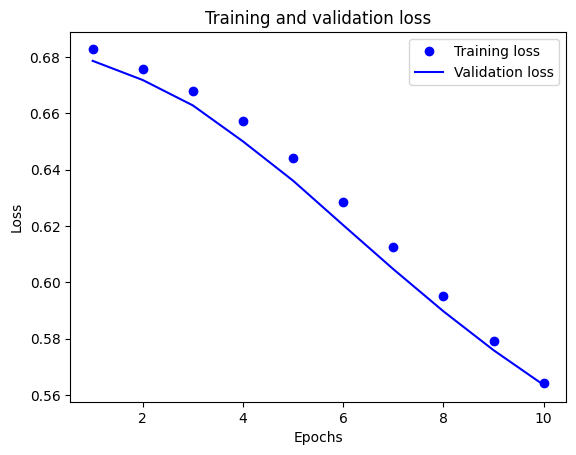

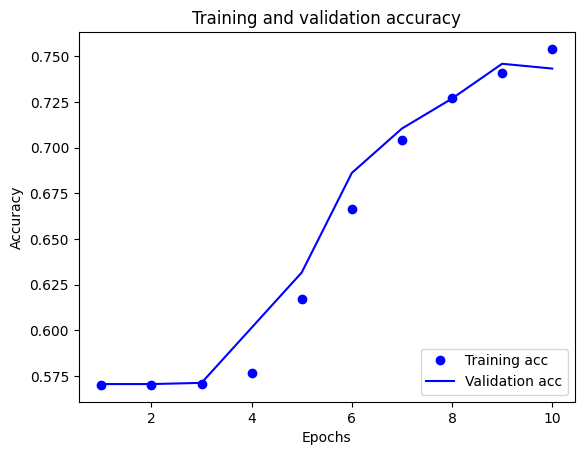

In [26]:
history = first_model.fit(x=train_ds, validation_data=val_ds, epochs=10)
plot_func(history)

From these two graphs, there is clearly room for improvement over more epoches for this model. The training and validation loss do not seem to have leveled off; similarly, the accuracies have also not seemed to level off. We can try again with additional epochs.

Epoch 1/25
96/96 [==============================] - 1s 6ms/step - loss: 0.6836 - accuracy: 0.5650 - val_loss: 0.6781 - val_accuracy: 0.5706
Epoch 2/25
96/96 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5703 - val_loss: 0.6710 - val_accuracy: 0.5706
Epoch 3/25
96/96 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.5704 - val_loss: 0.6611 - val_accuracy: 0.5712
Epoch 4/25
96/96 [==============================] - 0s 5ms/step - loss: 0.6554 - accuracy: 0.5826 - val_loss: 0.6488 - val_accuracy: 0.5955
Epoch 5/25
96/96 [==============================] - 0s 5ms/step - loss: 0.6419 - accuracy: 0.6271 - val_loss: 0.6339 - val_accuracy: 0.6428
Epoch 6/25
96/96 [==============================] - 0s 5ms/step - loss: 0.6258 - accuracy: 0.6708 - val_loss: 0.6181 - val_accuracy: 0.6914
Epoch 7/25
96/96 [==============================] - 0s 5ms/step - loss: 0.6100 - accuracy: 0.7108 - val_loss: 0.6070 - val_accuracy: 0.6697
Epoch 8/25
96/96 [==

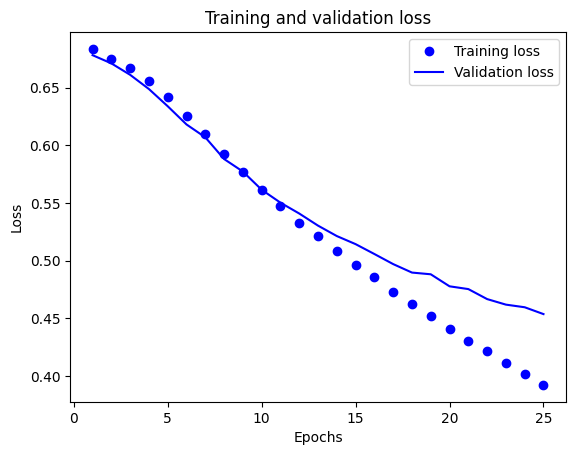

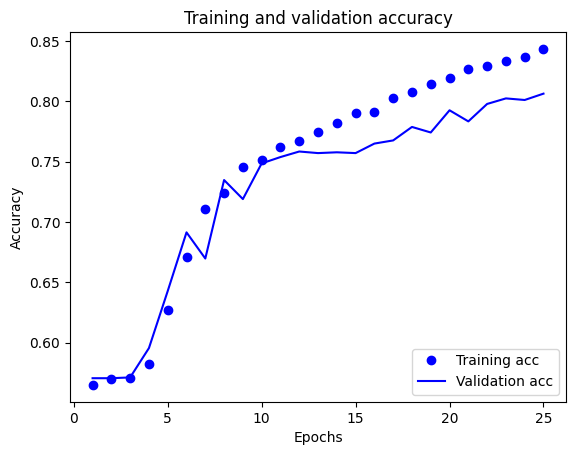

In [27]:
# clears first model's prior training
first_model = tf.keras.Sequential([
    layers.Embedding(max_features ,64),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

first_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

epochs = 25
history = first_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)
plot_func(history)

Unfortuntatly, it looks like the validation loss and accuracy are starting to level off. Accuracy of 0.8 is good, but we can try to improve the model instead of running additional epochs again.

We can see that this model's accuracy seems to maximize around 4 epochs. At that point, there also seems to be a steep increse in validation loss, which is bad.

In [28]:
second_model = tf.keras.Sequential([
    layers.Embedding(max_features,200),
    layers.LSTM(100),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

second_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=tf.optimizers.Adam())
second_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2120501 (8.09 MB)
Trainable params: 2120501 (8.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - 7s 53ms/step - loss: 0.6848 - accuracy: 0.5698 - val_loss: 0.6813 - val_accuracy: 0.5706
Epoch 2/10
96/96 [==============================] - 5s 50ms/step - loss: 0.5054 - accuracy: 0.7842 - val_loss: 0.4628 - val_accuracy: 0.7965
Epoch 3/10
96/96 [==============================] - 5s 51ms/step - loss: 0.3167 - accuracy: 0.8856 - val_loss: 0.4700 - val_accuracy: 0.8043
Epoch 4/10
96/96 [==============================] - 5s 48ms/step - loss: 0.2150 - accuracy: 0.9268 - val_loss: 0.4848 - val_accuracy: 0.7984
Epoch 5/10
96/96 [==============================] - 5s 49ms/step - loss: 0.1726 - accuracy: 0.9465 - val_loss: 0.6023 - val_accuracy: 0.7833
Epoch 6/10
96/96 [==============================] - 5s 49ms/step - loss: 0.1220 - accuracy: 0.9596 - val_loss: 0.8937 - val_accuracy: 0.7748
Epoch 7/10
96/96 [==============================] - 5s 49ms/step - loss: 0.1028 - accuracy: 0.9662 - val_loss: 0.8089 - val_accuracy: 0.7367
Epoch 8/10
96/96 [======

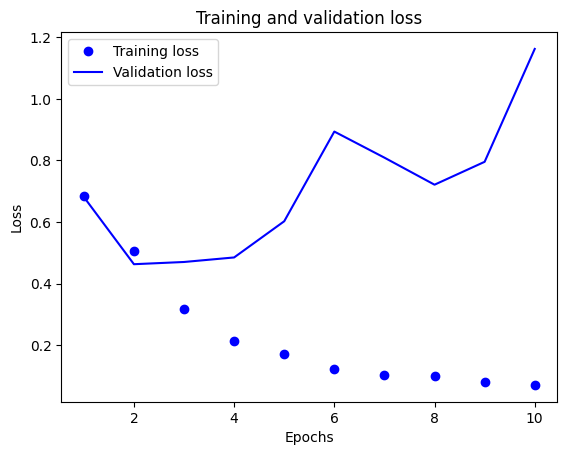

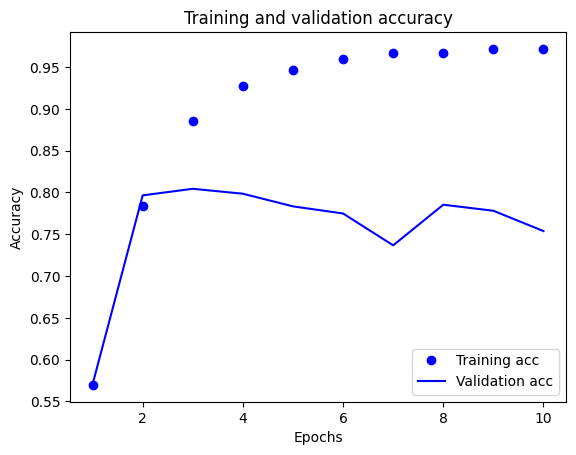

In [29]:
history = second_model.fit(x=train_ds, validation_data=val_ds, epochs=10)
plot_func(history)

In [30]:
third_model = tf.keras.Sequential([
    layers.Embedding(max_features,128),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

third_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=tf.optimizers.Adam())
third_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
96/96 [==============================] - 8s 51ms/step - loss: 0.5708 - accuracy: 0.7026 - val_loss: 0.4532 - val_accuracy: 0.7958
Epoch 2/10
96/96 [==============================] - 4s 45ms/step - loss: 0.3425 - accuracy: 0.8611 - val_loss: 0.4571 - val_accuracy: 0.8043
Epoch 3/10
96/96 [==============================] - 4s 42ms/step - loss: 0.2215 - accuracy: 0.9190 - val_loss: 0.4909 - val_accuracy: 0.7912
Epoch 4/10
96/96 [==============================] - 4s 42ms/step - loss: 0.1568 - accuracy: 0.9470 - val_loss: 0.5707 - val_accuracy: 0.7892
Epoch 5/10
96/96 [==============================] - 4s 42ms/step - loss: 0.1124 - accuracy: 0.9627 - val_loss: 0.7384 - val_accuracy: 0.7676
Epoch 6/10
96/96 [==============================] - 4s 42ms/step - loss: 0.0886 - accuracy: 0.9686 - val_loss: 0.7901 - val_accuracy: 0.7728
Epoch 7/10
96/96 [==============================] - 4s 45ms/step - loss: 0.0725 - accuracy: 0.9749 - val_loss: 0.9381 - val_accuracy: 0.7538
Epoch 8/10
96

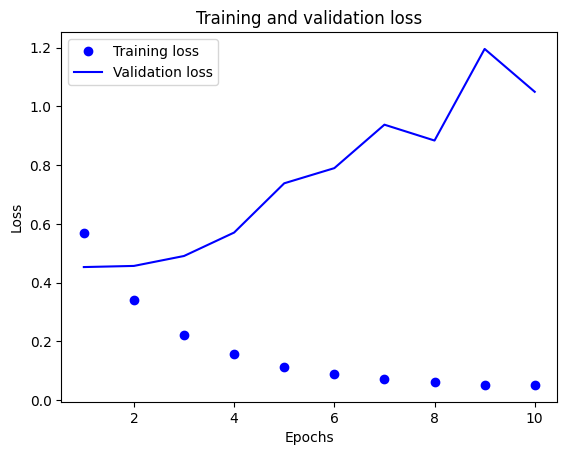

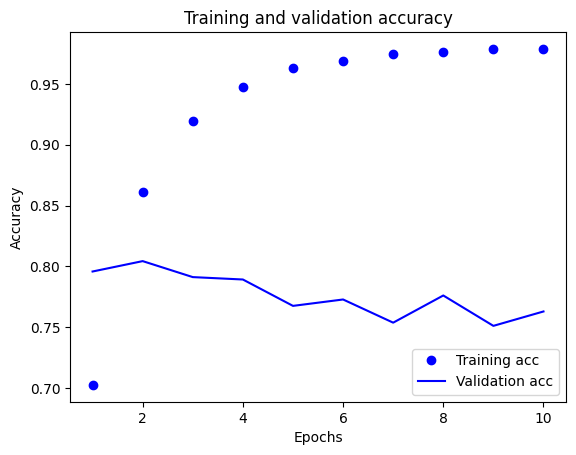

In [31]:
history = third_model.fit(x=train_ds, validation_data=val_ds, epochs=10)
plot_func(history)

Adding a LSTM (with and without bidirection) layer and dropout layer does not seem to improve performance overall, but does seem to achieve a higher taining accuracy from the first model. Overall, this model seems to cap out at a validation accuracy of 0.8, which is not bad, but definitly could be better.

## BERT Text Vectorization

We can shift to try and using a different type of word vectorization. Previously, we used a simple word to vector embedding based on all words in our dataset. We will now attempt to use BERT, a pre-trained model based on vocabulary from Wikipedia ([model link](https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/bert-en-uncased-l-4-h-512-a-8/versions/1?tfhub-redirect=true)).

In [32]:
# code taken from documentation
import tensorflow_text as text # Registers the ops.
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-128-a-2/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 128].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].

We can test what an example output of the model looks like.

In [33]:
# code taken from documentation
preprocessor_model = hub.KerasLayer(preprocessor)
text_preprocessed = preprocessor_model(['hello world'])
bert_model = hub.KerasLayer(encoder)
bert_model(text_preprocessed)

{'encoder_outputs': [<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
  array([[[-0.28209957,  0.16127399, -0.35150453, ...,  0.5077009 ,
            0.21340457,  1.9965067 ],
          [-1.5265744 ,  3.378838  ,  1.6338611 , ...,  0.12054971,
            1.1757679 ,  3.0933146 ],
          [ 0.08307905,  0.3280999 ,  0.07436036, ...,  2.4959233 ,
            0.99645245,  3.7378154 ],
          ...,
          [ 0.0132023 ,  0.61902344, -0.2620767 , ...,  0.02692477,
            0.39911288,  4.7912455 ],
          [ 0.16357262,  0.50296265,  0.23560297, ...,  0.01681199,
            0.02894995,  4.681708  ],
          [ 0.07864648, -0.0484555 ,  0.44076368, ..., -0.10352544,
           -0.49364454,  4.559942  ]]], dtype=float32)>,
  <tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
  array([[[ 0.0516504 ,  0.6599202 , -0.9217181 , ...,  0.30025643,
            0.43955854,  1.8802348 ],
          [ 0.6656793 ,  2.8988056 ,  1.0965407 , ...,  0.55948937,
            1.1671605 ,

Both these functions can be used within a model to convert the 'raw' (cleaned in this case) text data into vectors and then encodings.

In [34]:
def build_bert_model():
    # reload due to weight changing
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer(
        "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-128-a-2/versions/2",
        trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = layers.Dropout(0.5)(net)
    net = layers.Dense(1, activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)

bert_model = build_bert_model()
bert_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate=3e-5))
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_word_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [35]:
# this takes a while...
history = bert_model.fit(x=train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
96/96 [==============================] - 76s 708ms/step - loss: 0.6622 - accuracy: 0.6433 - val_loss: 0.4823 - val_accuracy: 0.7682
Epoch 2/5
96/96 [==============================] - 66s 687ms/step - loss: 0.5253 - accuracy: 0.7506 - val_loss: 0.4432 - val_accuracy: 0.7958
Epoch 3/5
96/96 [==============================] - 64s 670ms/step - loss: 0.4853 - accuracy: 0.7805 - val_loss: 0.4382 - val_accuracy: 0.8050
Epoch 4/5
96/96 [==============================] - 65s 682ms/step - loss: 0.4551 - accuracy: 0.7998 - val_loss: 0.4271 - val_accuracy: 0.8089
Epoch 5/5
96/96 [==============================] - 65s 677ms/step - loss: 0.4385 - accuracy: 0.8123 - val_loss: 0.4378 - val_accuracy: 0.8017


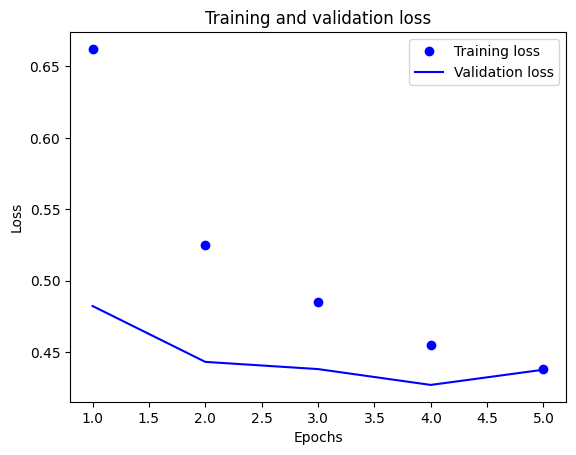

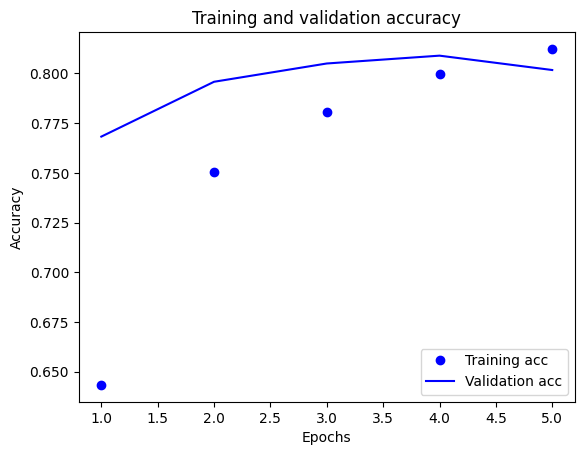

In [36]:
plot_func(history)

This model performs about as well as the previous models. We can try adding in additional layers. We can add a LSTM layer to make the model a recurrent neural network.

In [38]:
def build_bert_model2():
    # take vars from original load
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer(
        "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-128-a-2/versions/2",
        trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = layers.Dropout(0.5)(net)
    net = layers.Reshape((-1,1))(net)
    net = layers.LSTM(16,return_sequences=True)(net)
    net = layers.GlobalMaxPooling1D()(net) # forcing to the right output shape
    net = layers.Dense(1, activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)

bert_model2 = build_bert_model2()
bert_model2.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate = 0.0001))
bert_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_7 (KerasLayer)  {'input_word_ids': (None,    0         ['input_4[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [39]:
history = bert_model2.fit(x=train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
96/96 [==============================] - 79s 735ms/step - loss: 0.7132 - accuracy: 0.4297 - val_loss: 0.6782 - val_accuracy: 0.4353
Epoch 2/5
96/96 [==============================] - 68s 712ms/step - loss: 0.6669 - accuracy: 0.6300 - val_loss: 0.6384 - val_accuracy: 0.7997
Epoch 3/5
96/96 [==============================] - 69s 717ms/step - loss: 0.6024 - accuracy: 0.8074 - val_loss: 0.5737 - val_accuracy: 0.7978
Epoch 4/5
96/96 [==============================] - 69s 719ms/step - loss: 0.5154 - accuracy: 0.8307 - val_loss: 0.5436 - val_accuracy: 0.7820
Epoch 5/5
96/96 [==============================] - 70s 728ms/step - loss: 0.4462 - accuracy: 0.8545 - val_loss: 0.4942 - val_accuracy: 0.8083


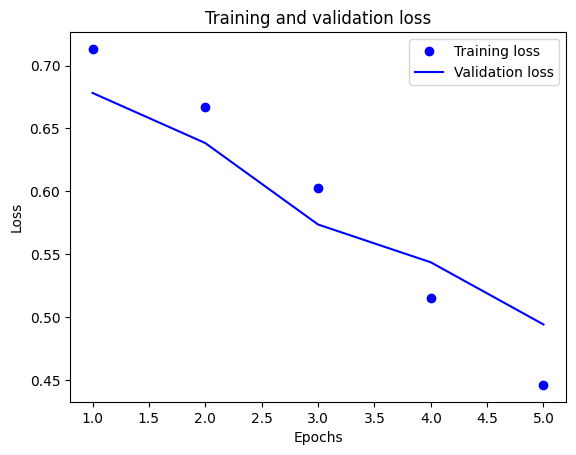

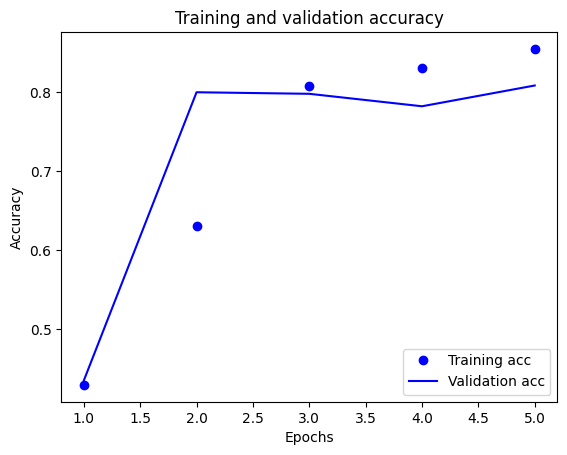

In [40]:
plot_func(history)

We can see that the model overall hits the same 0.80 maximum other models have achieved. We can try increasing the nodes in the LSTM layer and checking the performance.

In [41]:
def build_bert_model3():
    # take vars from original load
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer(
        "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-128-a-2/versions/2",
        trainable=True)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = layers.Dropout(0.5)(net)
    net = layers.Reshape((-1,1))(net)
    net = layers.LSTM(100,return_sequences=True)(net)
    net = layers.GlobalMaxPooling1D()(net) # forcing to the right output shape
    net = layers.Dense(1, activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)

bert_model3 = build_bert_model3()
bert_model3.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate = 0.0001))
history = bert_model3.fit(x=train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
96/96 [==============================] - 85s 792ms/step - loss: 0.6771 - accuracy: 0.5596 - val_loss: 0.6340 - val_accuracy: 0.5706
Epoch 2/5
96/96 [==============================] - 75s 778ms/step - loss: 0.5929 - accuracy: 0.5938 - val_loss: 0.5739 - val_accuracy: 0.7019
Epoch 3/5
96/96 [==============================] - 73s 766ms/step - loss: 0.5330 - accuracy: 0.7854 - val_loss: 0.5117 - val_accuracy: 0.7807
Epoch 4/5
96/96 [==============================] - 74s 770ms/step - loss: 0.4863 - accuracy: 0.8025 - val_loss: 0.4913 - val_accuracy: 0.8011
Epoch 5/5
96/96 [==============================] - 74s 770ms/step - loss: 0.4365 - accuracy: 0.8320 - val_loss: 0.4707 - val_accuracy: 0.8083


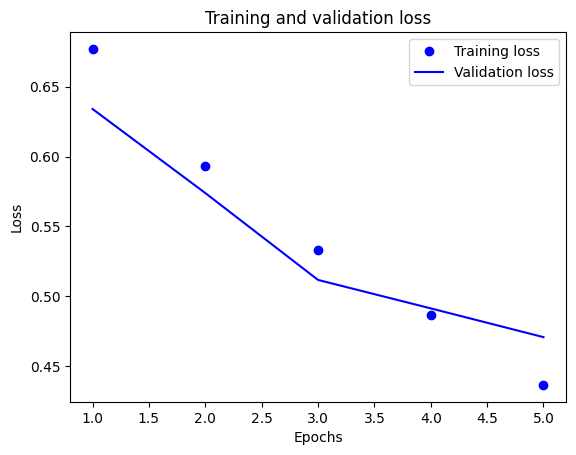

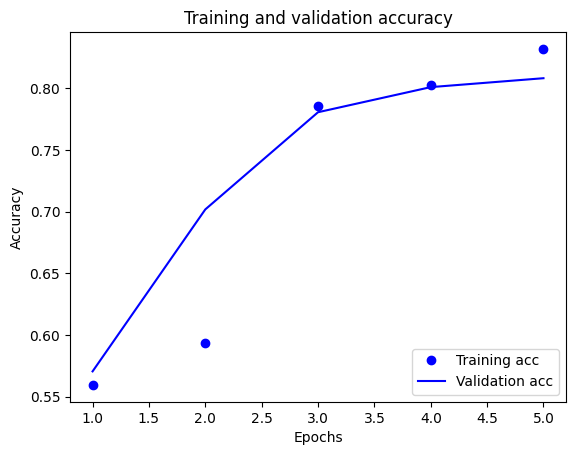

In [42]:
plot_func(history)

This model's performance is slightly better. It's possible the network could continued to be trained on more epochs and potentially would achieve a higher validation accuracy, but it does look to be leveling off at aroun the 5th epoch.

Out of all models, it seems like the last one had a good validation accuracy at around 0.8083 at epoch 5. We can use that model to further investigate the validation predictions and predict the final testing data.

In [ ]:
# model used in first submission
# def build_bert_model3():
#     # take vars from original load
#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
#     preprocessor = hub.KerasLayer(
#         "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
#     encoder_inputs = preprocessor(text_input)
#     encoder = hub.KerasLayer(
#         "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-4-h-128-a-2/versions/2",
#         trainable=True)
#     outputs = encoder(encoder_inputs)
#     net = outputs['pooled_output']
#     net = layers.Dropout(0.5)(net)
#     net = layers.Reshape((-1,1))(net)
#     net = layers.LSTM(100,return_sequences=True)(net)
#     net = layers.GlobalMaxPooling1D()(net) # forcing to the right output shape
#     net = layers.Dense(1, activation='sigmoid')(net)
#     return tf.keras.Model(text_input, net)

# bert_model3 = build_bert_model3()
# bert_model3.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam(learning_rate = 0.0001))
# history = bert_model3.fit(x=train_dataset, validation_data=test_dataset, epochs=3)

In [43]:
bert_model3.evaluate(test_dataset)
bert_pred = bert_model3.predict(test_dataset)

24/24 [==============================] - 6s 234ms/step


We can now look at what the model predicted for the validation testing set.

In [44]:
test_y = []
for i in list(test_dataset): #getting all labels from the tensor df
    for j in i[1]:
        test_y.append(int(j))

# turning into 1/0 predictions
bert_pred[bert_pred >= 0.5] = 1
bert_pred[bert_pred < 0.5] = 0 
bert_pred = bert_pred.reshape(1,-1)[0]
print('Lengths:', len(bert_pred), len(test_y))

Lengths: 1523 1523


Accuracy: 0.81
F1: 0.77
Precision: 0.79
Recall: 0.75


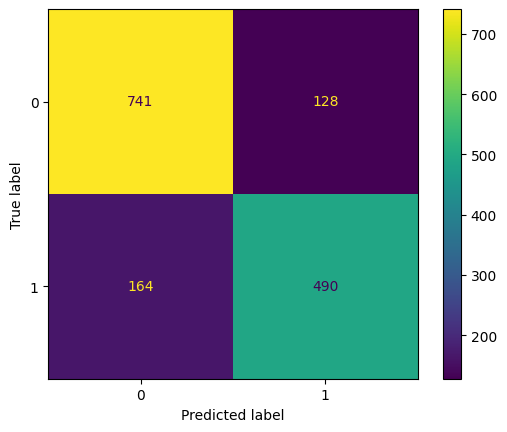

In [46]:
cm = confusion_matrix(test_y, bert_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
print('Accuracy: %.2f' %(accuracy_score(test_y, bert_pred)))
print('F1: %.2f' %(f1_score(test_y, bert_pred)))
print('Precision: %.2f' %(precision_score(test_y, bert_pred)))
print('Recall: %.2f' %(recall_score(test_y, bert_pred)))

Looking at the confusion matrix, it looks like the model misclassifies more instances of 0, or not disaster, as a disaster, instead of the inverse. 

We can now export the final predictions for the model and see how we did!

In [47]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_clean = test_df.copy()
test_clean['text'] = test_clean['text'].apply(remove_words)
test_clean['text'] = test_clean['text'].apply(remove_emojis)
test_clean['text'] = test_clean['text'].apply(remove_urls)

# Remove Punctuation (after removal of stop words with punctuation)
test_clean['text'] = test_clean['text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
test_clean['text'] = test_clean['text'].apply(lambda x: re.sub(' +', ' ', x))

tensor_finaltest_text = tf.convert_to_tensor(test_clean['text'].values)

In [48]:
ids = test_clean['id'].values
final_test_pred = bert_model3.predict(tensor_finaltest_text)
final_test_pred = final_test_pred.reshape(1,-1)[0]
final_test_pred[final_test_pred >= 0.5] = 1
final_test_pred[final_test_pred < 0.5] = 0 
final_df = pd.DataFrame(ids, columns=['id'])
final_df['target'] = final_test_pred
final_df['target'] = final_df['target'].astype('int')
final_df

102/102 [==============================] - 13s 126ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [49]:
# Checking to make sure our model didn't just predict 1s or 0s
final_df['target'].value_counts()

target
0    1994
1    1269
Name: count, dtype: int64

In [50]:
# final_df.to_csv('/kaggle/working/submission.csv', index=False)

## Conclusion

This was an interesting project to work on. It's intersting how many different ways to vectorize a sentence there is. It was also interesting to get inspiration on how to clean tweets from other notebooks in this project. I think there is definitly still room in my code to reduce the 'bad' tweet text like new line markers and various other text I wasn't exactly sure was doing.

The submitted model's predictions scored , which is better than a random guess. With an accuracy score of 0.786, the model performed fairly well. The test set accuracy was slightly less than the final model's validation accuracy. This is overall positive because it means the model did not overfit the training/validation data.

![](nlp-disasters-sequential-nn-screenshot.png)

# Referneces
- [https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python) (remove emoji Function)
- [https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet] (https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet) (remove URL Function)
- [https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string](https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string)  (remove additional spaces)
- [https://www.tensorflow.org/tutorials/load_data/pandas_dataframe](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe) () 
- [https://spacy.io/usage/embeddings-transformers#transformers-training](https://spacy.io/usage/embeddings-transformers#transformers-training) 
- [https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) 
- [https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/bert-en-uncased-l-4-h-512-a-8/versions/1?tfhub-redirect=true](https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/bert-en-uncased-l-4-h-512-a-8/versions/1?tfhub-redirect=true) (BERT Model)
- [https://www.tensorflow.org/tutorials/keras/text_classification](https://www.tensorflow.org/tutorials/keras/text_classification) 
- [https://www.tensorflow.org/text/tutorials/classify_text_with_bert](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) 
- [https://www.tensorflow.org/guide/keras/working_with_rnns#rnn_state_reuse](https://www.tensorflow.org/guide/keras/working_with_rnns#rnn_state_reuse) 
- [https://www.kaggle.com/code/christofhenkel/bert-embeddings-lstm](https://www.kaggle.com/code/christofhenkel/bert-embeddings-lstm) 
- [https://www.tensorflow.org/tutorials/keras/save_and_load](https://www.tensorflow.org/tutorials/keras/save_and_load) 